In [1]:
!git clone https://github.com/saisriteja/covid19.git

Cloning into 'covid19'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [2]:
!unzip /content/covid19/dataset.zip

Archive:  /content/covid19/dataset.zip
   creating: dataset/covid/
  inflating: dataset/covid/1-s2.0-S0140673620303706-fx1_lrg.jpg  
  inflating: dataset/covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg  
  inflating: dataset/covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg  
  inflating: dataset/covid/1-s2.0-S0929664620300449-gr2_lrg-c.jpg  
  inflating: dataset/covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg  
  inflating: dataset/covid/auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg  
  inflating: dataset/covid/auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg  
  inflating: dataset/covid/auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg  
  inflating: dataset/covid/auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg  
  inflating: dataset/covid/lancet-case2a.jpg  
  inflating: dataset/covid/lancet-case2b.jpg  
  inflating: dataset/covid/nCoV-radiol.2020200269.fig1-day7.jpeg  
  inflating: dataset/covid/nejmc20

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

In [0]:
from glob import glob


In [0]:
training_data = []

for i in glob('/content/dataset/covid/*.jpg'):
  img = cv2.imread(i)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  re = cv2.resize(img,(224,224),1)
  training_data.append([re,1])

for i in glob('/content/dataset/normal/*.jpeg'):
  img = cv2.imread(i)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  re = cv2.resize(img,(224,224))
  training_data.append([re,0])
  

In [0]:
from random import shuffle

In [0]:
shuffle(training_data)

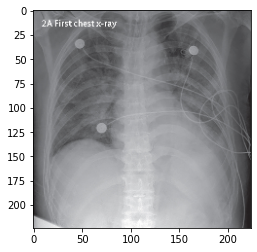

In [23]:
plt.imshow(training_data[0][0])

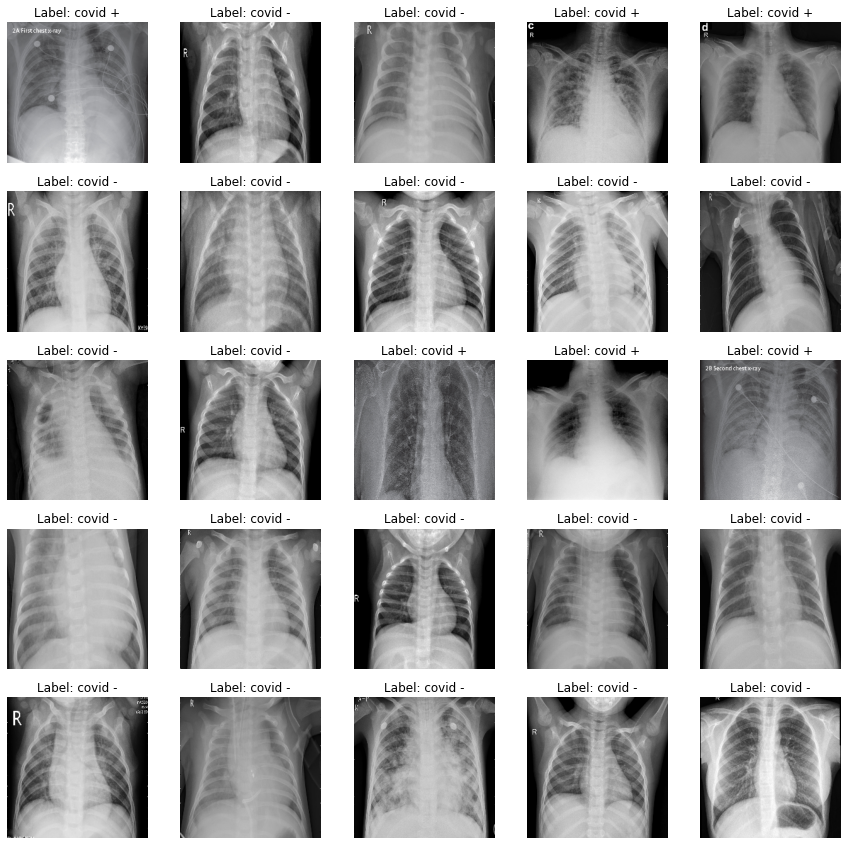

In [22]:
def show_images(data, isTest=False):
    f, ax = plt.subplots(5,5, figsize=(15,15))
    for i,data in enumerate(data[0:25]):
        img_num = data[1]
        img_data = data[0]
        label = img_num
        if label  == 1: 
            str_label='covid +'
        elif label == 0: 
            str_label='covid -'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    
    plt.show()

show_images(training_data)

In [0]:
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [0]:
data = []
labels = []
for i,j in training_data:
  data.append(i)
  labels.append(j)

In [0]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
(trainX, testX, trainY, testY) = train_test_split(np.array(data), np.array(labels),
	test_size=0.20, stratify=labels, random_state=42)

In [28]:
print(trainX.shape,trainY.shape)

(26, 224, 224, 3) (26, 2)


In [31]:

# and batch size
INIT_LR = 1e-3
EPOCHS = 25
BS = 4
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
  horizontal_flip =True,zca_whitening=True,vertical_flip=True,
	rotation_range=15,
	fill_mode="nearest")

# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = keras.applications.resnet.ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


[INFO] compiling model...
[INFO] training head...
Epoch 1/25


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


6/6 [==============================] - 2s 255ms/step - loss: 0.5461 - accuracy: 0.7500 - val_loss: 0.5520 - val_accuracy: 0.7143
Epoch 2/25
6/6 [==============================] - 0s 44ms/step - loss: 0.5244 - accuracy: 0.8182 - val_loss: 1.3105 - val_accuracy: 0.7143
Epoch 3/25
6/6 [==============================] - 0s 44ms/step - loss: 1.2582 - accuracy: 0.8182 - val_loss: 0.3139 - val_accuracy: 0.8571
Epoch 4/25
6/6 [==============================] - 0s 47ms/step - loss: 0.3797 - accuracy: 0.8182 - val_loss: 0.2352 - val_accuracy: 0.8571
Epoch 5/25
6/6 [==============================] - 0s 46ms/step - loss: 0.1526 - accuracy: 0.9091 - val_loss: 0.0825 - val_accuracy: 1.0000
Epoch 6/25
6/6 [==============================] - 0s 43ms/step - loss: 0.1443 - accuracy: 0.9091 - val_loss: 0.0327 - val_accuracy: 1.0000
Epoch 7/25
6/6 [==============================] - 0s 45ms/step - loss: 0.1826 - accuracy: 0.9545 - val_loss: 0.0266 - val_accuracy: 1.0000
Epoch 8/25
6/6 [=====================

In [0]:
pred = model.predict(testX)

In [33]:
model.evaluate(testX,testY)

1/1 [==============================] - 0s 1ms/step - loss: 0.0388 - accuracy: 1.0000


[0.03884020075201988, 1.0]

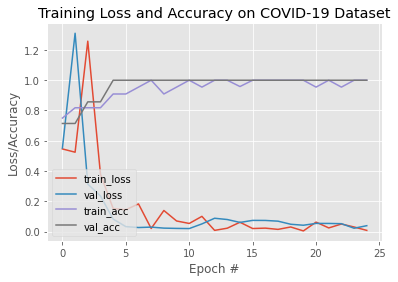

In [34]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('fig.png')

In [35]:
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[5 0]
 [0 2]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000
